<a href="https://colab.research.google.com/github/eulerleonhard/Telecommunication_System_RadioML_HUST/blob/main/radioML2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radio Modulation Recognition Networks

---

**Author: Ngân Hà**

---

**The code structure is following:**


*   **Imports** - Import needed libraries
*   **Defined Functions** - Functions defined for an easier manipulation with the data later on
*   **Accessing the datasets** - you may skip this part and download the datasets elsewhere if you please
*   **Loading Data** - Load the data and divide them into training, validation and test sets
*   **Deep Learning Part** -Contains the architectures, which are prepared to be trained and evaluated
*   **Load Trained Model** - Optionaly you can download the CGDNN model and see how it does on the corresponding dataset
*   **Layer Visualization** - A part of code which was written to visualize the activation maps of the convolutional and recurrent layers
*   **Plotting** - You can plot the confusion matrices in this part

---

**Quick guide to running the document:**

*   Use `up` and `down` keys to move in the notebook
*   Use `ctrl+enter` to run cell or choose 'Run All' in Runtime to run the whole document at once
*   If you change something in specific cell, it's enough to re-run just the cell to save the changes
*   Hide/show sections of the code with the arrows at side, which are next to some cell code
* In the top left part you can click on the Content icon, which will allow you to navigate easier through this notebook







In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#%cd '/content/drive/MyDrive/Colab Notebooks/BTL HTVT/RadioML2018/data'

Mounted at /content/drive


In [ ]:
%pwd

'/home/fil-server'

# Crawl [radioML2018.01A dataset](https://www.kaggle.com/aliayub/radioml2018) from Kaggle

## Set up Kaggle enviroment

### Ensure that you've already upload the kaggle.json file to /content

In [ ]:
### Ensure that you've already upload the kaggle.json file to /content
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 58 kB 401 kB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 76 kB 1.2 MB/s            
     |████████████████████████████████| 78 kB 1.4 MB/s             
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=31dcceb5e8b58133bef2ec3e7e04afce7553035e706e742ee2698ffb568dc8e4
  Stored in directory: /home/fil-server/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
mkdir: cannot create directory ‘/home/fil-server/.kaggle’: File exists


In [ ]:
%cd 'radioML2018'

/home/fil-server/radioML2018


In [ ]:
! kaggle datasets download pinxau1000/radioml2018

100%|████████████████████████████████████| 18.0G/18.0G [2:14:05<00:00, 2.43MB/s]
100%|████████████████████████████████████| 18.0G/18.0G [2:14:05<00:00, 2.40MB/s]


In [ ]:
! unzip '/home/fil-server/radioML2018/radioml2018.zip'

Archive:  /home/fil-server/radioML2018/radioml2018.zip
  inflating: GOLD_XYZ_OSC.0001_1024.hdf5  
  inflating: LICENSE.TXT             
  inflating: classes-fixed.json      
  inflating: classes-fixed.txt       
  inflating: classes.txt             
  inflating: datasets.desktop        


## Visualize data example

In [ ]:
!pip install pyyaml h5py
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.3 MB 2.5 MB/s            
     |████████████████████████████████| 895 kB 2.7 MB/s            
     |████████████████████████████████| 1.2 MB 3.3 MB/s            


Retrieving Sample 235711
	- Modulation (raw): [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	- Modulation: 8ASK
	- SNR: [-10]
	- Samples: [[ 0.41141438  0.0955532 ]
 [-0.02774137  0.16980176]
 [ 0.11000113  0.28186926]
 ...
 [ 0.97717977  0.6372246 ]
 [ 0.6477459  -1.0259153 ]
 [ 0.38088095 -0.77991676]]


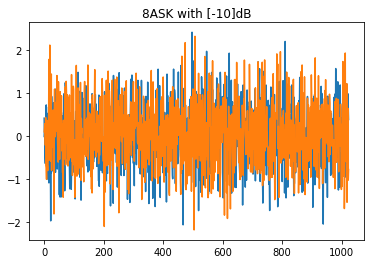

In [ ]:
import h5py
import json
from numpy import argwhere
from matplotlib import pyplot as plt

# Open the dataset
hdf5_file = h5py.File("GOLD_XYZ_OSC.0001_1024.hdf5",  'r')
# Load the modulation classes. You can also copy and paste the content of classes-fixed.txt.
modulation_classes = json.load(open("classes-fixed.json", 'r'))

# Read the HDF5 groups
data = hdf5_file['X']
modulation_onehot = hdf5_file['Y']
snr = hdf5_file['Z']

# Sets the frame number
idx = 235711

# Converts the onehot encoded modulation to a readable string
modulation_str = modulation_classes[int(argwhere(modulation_onehot[idx] == 1))]

# Prints info about the frame
print(f"Retrieving Sample {idx}\n"
      f"\t- Modulation (raw): {modulation_onehot[idx]}\n"
      f"\t- Modulation: {modulation_str}\n"
      f"\t- SNR: {snr[idx]}\n"
      f"\t- Samples: {data[idx]}")

plt.rcParams["figure.figsize"] = (9,4)

for i in [0]:
    plt.plot(signals[i,0,:],label=r'I')
    plt.plot(signals[i,1,:],label=r'Q')
    plt.xlabel(r'Sample')
    plt.title( classes[modulations[i]].decode("utf-8") )
    plt.grid()
    plt.legend()
    plt.show()

# Plot IQ samples of the frame
plt.figure()
plt.title(f"{modulation_str} with {snr[idx]}dB")
plt.plot(data[idx])
plt.show()

# Closes the file
#hdf5_file.close()

In [ ]:
import numpy as np
import pickle

# Show loss curves
def show_history(history):
    plt.figure()
    plt.title('Training loss performance')
    plt.plot(history.epoch, history.history['loss'], label='train loss+error')
    plt.plot(history.epoch, history.history['val_loss'], label='val_error')
    plt.legend()
    plt.show()

    plt.figure()
    plt.title('Training accuracy performance')
    plt.plot(history.epoch, history.history['acc'], label='train_acc')
    plt.plot(history.epoch, history.history['val_acc'], label='val_acc')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[],save_filename=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save_filename is not None:
        plt.savefig(save_filename)
    plt.show()

def calculate_confusion_matrix(Y,Y_hat,classes):
    n_classes = len(classes)
    conf = np.zeros([n_classes,n_classes])
    confnorm = np.zeros([n_classes,n_classes])

    for k in range(0,Y.shape[0]):
        i = list(Y[k,:]).index(1)
        j = int(np.argmax(Y_hat[k,:]))
        conf[i,j] = conf[i,j] + 1

    for i in range(0,n_classes):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    # print(confnorm)

    right = np.sum(np.diag(conf))
    wrong = np.sum(conf) - right
    return confnorm,right,wrong

def calculate_accuracy_each_snr(Y,Y_hat,Z,classes=None):
    Z_array = Z[:,0]
    snrs = sorted(list(set(Z_array)))
    # snrs = np.arange(-20,32,2)
    acc = np.zeros(len(snrs))

    Y_index = np.argmax(Y,axis=1)
    Y_index_hat = np.argmax(Y_hat,axis=1)

    i = 0
    for snr in snrs:
        Y_snr = Y_index[np.where(Z_array == snr)]
        Y_hat_snr = Y_index_hat[np.where(Z_array == snr)]

        acc[i] = np.sum(Y_snr==Y_hat_snr)/Y_snr.shape[0]
        i = i +1

    plt.figure(figsize=(8, 6))
    plt.plot(snrs,acc, label='test_acc')
    plt.xlabel("Signal to Noise Ratio")
    plt.ylabel("Classification Accuracy")
    plt.title("Classification Accuracy on RadioML 2018.01")
    plt.legend()
    plt.grid()
    plt.show()

'''
Through the confusion matrix under a certain snr, calculate the acc of each type of signal under the snr, and return a column
'''
def calculate_acc_at1snr_from_cm(cm):
    return np.round(np.diag(cm)/np.sum(cm,axis=1),3)

def calculate_acc_cm_each_snr(Y,Y_hat,Z,classes=None,save_figure=True,min_snr = 0):
    Z_array = Z[:,0]
    snrs = sorted(list(set(Z_array)))
    acc = np.zeros(len(snrs))

    acc_mod_snr = np.zeros( (len(classes),len(snrs)) )  #mods*snrs,24*26
    i = 0
    for snr in snrs:
        Y_snr = Y[np.where(Z_array == snr)]
        Y_hat_snr = Y_hat[np.where(Z_array == snr)]

        # plot confusion for each snr
        cm,right,wrong = calculate_confusion_matrix(Y_snr,Y_hat_snr,classes)
        print(min_snr)
        if snr >= min_snr:
            plot_confusion_matrix(cm, title='Confusion matrix at {}db'.format(snr), cmap=plt.cm.Blues, labels=classes,save_filename = 'figure/cm_snr{}.png'.format(snr))

        # cal acc on each snr
        acc[i] = round(1.0*right/(right+wrong),3)
        print('Accuracy at %ddb:%.2f%s / (%d + %d)' % (snr,100*acc[i],'%',right, wrong))

        acc_mod_snr[:,i] = calculate_acc_at1snr_from_cm(cm)

        i = i +1

    '''
    The change curve of acc with snr
    '''
    plt.figure(figsize=(8, 6))
    plt.plot(snrs,acc, label='test_acc')
    # Set number labels
    for x, y in zip(snrs,acc):
        plt.text(x, y, y, ha='center', va='bottom', fontsize=8)

    plt.xlabel("Signal to Noise Ratio")
    plt.ylabel("Classification Accuracy")
    plt.title("Classification Accuracy on All Test Data")
    plt.legend()
    plt.grid()
    plt.savefig('figure/acc_overall.png')
    plt.show()

    fd = open('acc_overall_128k_on_512k_wts.dat', 'wb')
    pickle.dump(('128k','512k', acc), fd)
    fd.close()

    '''
    acc changes curve with snr, one curve per mod
    '''
    dis_num = 6
    for g in range(int(np.ceil(acc_mod_snr.shape[0]/dis_num))):
        assert (0 <= dis_num <= acc_mod_snr.shape[0])
        beg_index = g*dis_num
        end_index = np.min([(g+1)*dis_num,acc_mod_snr.shape[0]])

        plt.figure(figsize=(12, 10))
        plt.xlabel("Signal to Noise Ratio")
        plt.ylabel("Classification Accuracy")
        plt.title("Classification Accuracy for Each Mod")

        for i in range(beg_index,end_index):
            plt.plot(snrs, acc_mod_snr[i], label=classes[i])
            # Set number labels
            for x, y in zip(snrs, acc_mod_snr[i]):
                plt.text(x, y, y, ha='center', va='bottom', fontsize=8)

        plt.legend()
        plt.grid()
        if save_figure:
            plt.savefig('figure/acc_with_mod_{}.png'.format(g+1))
        plt.show()

    fd = open('acc_for_mod_on_1m_wts.dat', 'wb')
    pickle.dump(('128k','1m', acc_mod_snr), fd)
    fd.close()
    # print(acc_mod_snr)

0

# **Preambule**

## Importing


In [ ]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 489.6 MB 25 kB/s              
     |████████████████████████████████| 5.8 MB 777 kB/s            
     |████████████████████████████████| 463 kB 2.0 MB/s            
     |████████████████████████████████| 1.1 MB 2.7 MB/s            
     |████████████████████████████████| 84 kB 839 kB/s            
     |████████████████████████████████| 4.1 MB 3.0 MB/s            
     |████████████████████████████████| 42 kB 362 kB/s            
     |████████████████████████████████| 65 kB 2.1 MB/s            
     |████████████████████████████████| 57 kB 915 kB/s            
     |████████████████████████████████| 1.3 MB 3.5 MB/s            
     |████████████████████████████████| 2.1 MB 3.6 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 126 kB 3.6 MB/s            
     |████████████████████████████████| 14.5 MB 2.2 MB/s      

In [ ]:
import sys
from os import mkdir
from os.path import exists as path_exists
from os.path import join
import time

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib
from tensorflow import convert_to_tensor
from tensorflow.keras.backend import clear_session

print(f'Available devices:\n{[x.name for x in device_lib.list_local_devices()]}')

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, AlphaDropout, GlobalAveragePooling1D, BatchNormalization, add
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, Activation
from tensorflow.keras.layers import Conv1D, AveragePooling1D, ZeroPadding2D, Convolution2D, MaxPooling1D, MaxPooling2D


2022-01-29 21:05:54.792396: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-29 21:05:54.792419: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Available devices:
['/device:CPU:0']


2022-01-29 21:05:56.545091: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-29 21:05:56.546737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-29 21:05:56.546758: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-29 21:05:56.546776: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fil-server-08): /proc/driver/nvidia/version does not exist


In [ ]:
for lib in ['tensorflow','numpy','matplotlib']:
    print(f'{lib} version = {__import__(lib).__version__}')

tensorflow version = 2.7.0
numpy version = 1.22.1
matplotlib version = 3.5.1


In [ ]:
np.random.seed(2022)

## General settings

In [ ]:
# Please specify the folder where your dataset(s) is/are
data_path = '/home/fil-server/radioML2018' # <your data path>

# Please specify a folder to log information during model training
log_path = '/home/fil-server/radioML2018' # <your log path>

if not path_exists(log_path):
    mkdir(log_path)

## Dataset settings and Training settings

In [ ]:
# Dataset setting
dataset_name = 'radioML2018.01A'
signal_duration = 1024
snr_cut = 0

# Training setting
nb_epoch = 200
batch_size = 512

# **Data utils**

In [ ]:
import time
from tensorflow.keras.callbacks import Callback
from numpy.random import choice

class TimeHistory(Callback):
    """ Keras callback tto monitor execution time during training
    """
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def split_dataset( data, labels,
                    p_train=0.8, p_valid=0.0, p_test=0.0,
                    ):
    """ Function to split and shuffle a dataset into train, validation and test
        splits.
        Arguments:
        data (tensor): input dataset
        labels (tensor): label vector associated to data
        p_train (float): proportion of training data
        p_valid (float): proportion of validation data
        p_test (float): proportion of test data
    """

    def aux(D_ , L_,  p_, idx_):

        n_tot_examples_ = D_.shape[0]
        n_taken_examples_ = int(n_tot_examples_ * p_ )
        chosen_idx_ = choice(idx_ , size=n_taken_examples_, replace=False)
        free_indexes_ = list( set(idx_) - set( chosen_idx_ ) )

        return D_[chosen_idx_] , L_[chosen_idx_] , chosen_idx_, free_indexes_

    D = data
    L = labels

    idx = range(0, D.shape[0])
    X_train , Y_train, train_idx, free_idx = aux(D , L, p_train ,  idx)

    idx = free_idx
    X_valid , Y_valid, valid_idx, free_idx = aux(D , L, p_valid ,  idx)

    idx = free_idx
    X_test, Y_test, test_idx,free_idx = aux(D , L, p_test ,  idx)

    return X_train , Y_train , train_idx, X_valid , Y_valid, valid_idx, X_test , Y_test,test_idx

    pass

# **Data loading and preparation**

Load the selected dataset ;

This cell outputs:

`signals` : a numpy array containing signal data

`class_onehot` : a numpy array containing one hot encoded labels associated to data

`snrs`: an array associating snr to each signal

`class_list`: a list of strings associating the modulation / signal kind name to the indexes of labels

In [ ]:
from h5py import File
from numpy import array, zeros, sqrt, mean, vstack
from numpy.random import choice
import pickle

def read_RML2018(fName ,nb_examples = None):
    """ Open datasets from Radio Machine Learning 2018
    Args:
        fname (str, optional): [description]. Defaults to './2016.04C.multisnr.pkl'.
        snrs (list of int, optional): list of snrs to keep. If None keeps all.  Defaults to None.
        verbose (bool): set verbosity
    Returns:
        (tuple of arrays): data, labels, snrs, None
    """
    with File(fName,'r') as h:

        if not nb_examples is None:
            w = choice(h['X'].shape[0], size=nb_examples, replace=False)
            data = h['X'][:][w]
            mods_ = h['Y'][:][w]
            snrs_ = h['Z'][:][w]
        else:
            data = h['X'][:]
            mods_ = h['Y'][:]
            snrs_ = h['Z'][:]

    snrs_ = snrs_.flatten()
    snrs_=snrs_.reshape(-1)
    data = data.transpose((0,2,1))

    return data, mods_, snrs_,None

In [ ]:
signals, class_onehot, snrs ,class_list = read_RML2018('/home/fil-server/radioML2018/GOLD_XYZ_OSC.0001_1024.hdf5')
class_idx = np.argmax(class_onehot,axis=-1)

In [ ]:
snrs_list = sorted( list( set( snrs ) ) )

print(f'{dataset_name} loaded, {signals.shape[0]} signal with shape {signals.shape[1:]}' )
print(f'List of signal SNR: {snrs_list}')
print(f'List of modulations under consideration: {class_list}')

radioML2018.01A loaded, 2555904 signal with shape (2, 1024)
List of signal SNR: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
List of modulations under consideration: None


Transposes the data so the real/imag axis is the last as expected by deep learning models


In [ ]:
print(f'Initial data shape: {signals.shape}')
signals = signals.transpose((0,2,1))
print(f'Transposed data shape: {signals.shape}' )

Initial data shape: (2555904, 2, 1024)
Transposed data shape: (2555904, 1024, 2)


Trunk signal to `signal_duration` samples.

In [ ]:
if not signal_duration is None:
    print(f'Initial data shape: {signals.shape}')
    signals = signals[:,:signal_duration,:]
    print(f'Trunked data shape: {signals.shape}' )


Initial data shape: (2555904, 1024, 2)
Trunked data shape: (2555904, 1024, 2)


Filters signal by snr if requested above

In [ ]:
if not snr_cut is None:
    print(f'Initial data shape: {signals.shape}')
    w = snrs>=snr_cut
    signals = signals[w]
    class_idx = class_idx[w]
    snrs = snrs[w]
    class_onehot = class_onehot[w]
    print(f'New data shape: {signals.shape}' )

Initial data shape: (2555904, 1024, 2)
New data shape: (1572864, 1024, 2)


Normalize the power of each signal

In [ ]:
### Normalize the power of each signal
norm = np.sqrt(np.mean(signals**2,axis=(1,2),keepdims=True))
signals/=norm

Split dataset into train and test sets. Also shuffles data.

In [ ]:
X_train, y_train, train_idx ,_,_,_, X_test,y_test,test_idx= split_dataset(signals,
    class_onehot,
    p_train=0.5,p_test=0.5)

SNR_train = snrs[train_idx]
SNR_test = snrs[test_idx]

print(f'Train dataset shape: {X_train.shape}')
print(f'Test dataset shape: {X_test.shape} ')

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test  shape: {X_test.shape}, y_test  shape: {y_test.shape}')

input_shp = list(X_train.shape[1:])
output_shp = y_train.shape[1]

print(f'Network input shape in variable input-shp: {input_shp}')
print(f'Network output shape in variable input-shp: {output_shp}')


X_train = convert_to_tensor(X_train)
y_train = convert_to_tensor(y_train)
X_test = convert_to_tensor(X_test)
y_test = convert_to_tensor(y_test)

Train dataset shape: (786432, 1024, 2)
Test dataset shape: (786432, 1024, 2) 
X_train shape: (786432, 1024, 2), y_train shape: (786432, 24)
X_test  shape: (786432, 1024, 2), y_test  shape: (786432, 24)
Network input shape in variable input-shp: [1024, 2]
Network output shape in variable input-shp: 24


2022-02-05 16:37:03.472170: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6442450944 exceeds 10% of free system memory.
2022-02-05 16:37:07.565731: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6442450944 exceeds 10% of free system memory.


# **Deep learning model training**

Define a function to instanciate and train a deep learning model

In [ ]:
def train_model(model,name_network):

    clear_session()
    time_callback = TimeHistory()

    history = model.fit(X_train, y_train,
                        epochs=nb_epoch, batch_size=batch_size,
                        validation_data =( X_test , y_test ),
                        verbose=1,
                        callbacks=[time_callback])

    model.save(join(log_path,'model-{}-{}-trained{}.h5'.format(dataset_name,name_network,signal_duration)))

    data = np.array(list(zip(history.epoch, history.history['val_accuracy'], history.history['accuracy'])))
    np.savetxt(join(log_path,'history-{}-{}-trained{}.txt'.format(dataset_name,name_network,signal_duration)),data)

    data = np.array(list(zip(history.epoch, time_callback.times)))
    np.savetxt(join(log_path,'history_time-{}-{}-trained{}.txt'.format(dataset_name,name_network,signal_duration)),data)

    clear_session()

## Model Structures

In [ ]:
  def residual_stack(X,Filters,Seq,max_pool):
      """ Auxiliary function to generate RML CNN/VGG  as defined in O'Shea et Al., Over-the-Air Deep Learning
          Based Radio Signal Classification,  2018. The implementation is an adaptation of
          https://github.com/liuzhejun/ResNet-for-Radio-Recognition/blob/master/ResNet_Model.ipynb
      Arguments:
          X (tensor): input
          Filters (int): number of filters
          Seq (str): module name
          max_pool (bool): enable max pooling at the end
      """

      #1*1 Conv Linear
      X = Convolution2D(Filters, (1, 1), padding='same',
                        name=Seq+"_conv1", kernel_initializer='glorot_uniform',
                        data_format="channels_last")(X)

      #Residual Unit 1
      X_shortcut = X
      X = Convolution2D(Filters, (3, 2), padding='same',activation="relu",
                        name=Seq+"_conv2", kernel_initializer='glorot_uniform',
                        data_format="channels_last")(X)

      X = Convolution2D(Filters, (3, 2), padding='same',
                        name=Seq+"_conv3", kernel_initializer='glorot_uniform',
                        data_format="channels_last")(X)

      X = add([X,X_shortcut])
      X = Activation("relu")(X)

      #Residual Unit 2
      X_shortcut = X
      X = Convolution2D(Filters, (3, 2), padding='same',activation="relu",
                        name=Seq+"_conv4", kernel_initializer='glorot_uniform',
                        data_format="channels_last")(X)

      X = Convolution2D(Filters, (3, 2), padding='same',
                        name=Seq+"_conv5", kernel_initializer='glorot_uniform',
                        data_format="channels_last")(X)

      X = add([X,X_shortcut])
      X = Activation("relu")(X)

      #MaxPooling
      if max_pool:
          X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid',
                          data_format="channels_last")(X)

      return X


In [ ]:
class neural_nets_keras:
  def get_LModCNN(input_shp,output_shp,verbose=False):
      """ Generate LModCNN architecture as defined in Courtat and du Mas des Bourboux,
          A light neural network for modulation detection under impairments, ISNCC 2021
      Arguments:
          input_shp (list): shape of the input data [signal_length,2], batch is omitted
          output_shp (list): shape of the output data [n_classes]
          verbose (bool): set verbosity
      """
      model = Sequential()

      model.add(Conv1D(filters=8, kernel_size=7, activation='relu', padding="same",input_shape=input_shp))

      model.add(Conv1D(filters=16, kernel_size=7, activation='relu', padding="same"))

      model.add(Conv1D(filters=32, kernel_size=7, activation='relu', padding="same"))

      model.add(Conv1D(filters=64, kernel_size=7, activation='relu', padding="same"))

      model.add(GlobalAveragePooling1D())

      model.add(Dense(units=256, activation='relu', kernel_initializer='he_normal'))
      model.add(Dropout(rate=0.5))

      model.add(Dense(output_shp, activation='softmax', kernel_initializer='he_normal'))

      if verbose:
          model.summary()

      return model

  def get_LModCNNResNetRelu(input_shp,output_shp,verbose=False):
      """ Generate LMod CNN with residual connexion architecture as defined in Courtat and du Mas des Bourboux,
          A light neural network for modulation detection under impairments, ISNCC 2021
      Arguments:
          input_shp (list): shape of the input data [signal_length,2], batch is omitted
          output_shp (list): shape of the output data [n_classes]
          verbose (bool): set verbosity
      """
      kernel_size = 7

      X_input = Input(input_shp)

      X = Conv1D(filters=8, kernel_size=1, activation='relu', padding="same",
                input_shape=input_shp,
                kernel_initializer='glorot_uniform')(X_input)

      X_shortcut = X

      X = Conv1D(filters=8, kernel_size=kernel_size, activation='relu', padding="same",
                kernel_initializer='glorot_uniform')(X)
      X = Conv1D(filters=8, kernel_size=kernel_size, padding="same",
                kernel_initializer='glorot_uniform')(X)
      X = add([X,X_shortcut])
      X = Activation("relu")(X)

      X = Conv1D(filters=16, kernel_size=1, activation='relu', padding="same",
                kernel_initializer='glorot_uniform')(X)

      X_shortcut = X

      X = Conv1D(filters=16, kernel_size=kernel_size, activation='relu', padding="same",
                kernel_initializer='glorot_uniform')(X)
      X = Conv1D(filters=16, kernel_size=kernel_size, padding="same",
                kernel_initializer='glorot_uniform')(X)
      X = add([X,X_shortcut])
      X = Activation("relu")(X)

      X = Conv1D(filters=32, kernel_size=1, activation='relu', padding="same",
                kernel_initializer='glorot_uniform')(X)

      X_shortcut = X

      X = Conv1D(filters=32, kernel_size=kernel_size, activation='relu', padding="same",
                kernel_initializer='glorot_uniform')(X)
      X = Conv1D(filters=32, kernel_size=kernel_size, padding="same",
                kernel_initializer='glorot_uniform')(X)
      X = add([X,X_shortcut])
      X = Activation("relu")(X)

      X = Conv1D(filters=64, kernel_size=1, activation='relu', padding="same",
                kernel_initializer='glorot_uniform')(X)

      X_shortcut = X

      X = Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding="same",
                kernel_initializer='glorot_uniform')(X)
      X = Conv1D(filters=64, kernel_size=kernel_size, padding="same",
                kernel_initializer='glorot_uniform')(X)
      X = add([X,X_shortcut])

      X = Activation("relu")(X)

      X = GlobalAveragePooling1D()(X)

      X = Dense(units=256, activation='relu', kernel_initializer='he_normal')(X)
      X = Dropout(rate=0.5)(X)

      X = Dense(output_shp, activation='softmax', kernel_initializer='he_normal')(X)

      model = Model(inputs=X_input,outputs=X)

      if verbose:
          model.summary()

      return model

  def get_RMLConvNet(input_shp,output_shp,verbose=False):
      """ Generate RMLConvNet as defined in O'Shea et Al., Convolutional radio
      modulation recognition networks, 2016
      the implementation is an adaptation of
      https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb
      Arguments:
      input_shp (list): shape of the input data [signal_length,2], batch is omitted
      output_shp (list): shape of the output data [n_classes]
      verbose (bool): set verbosity
      """

      dr = 0.5

      model = Sequential()
      model.add(Reshape(input_shp+[1], input_shape=input_shp))

      model.add(ZeroPadding2D((2, 0), data_format='channels_last'))
      model.add(Convolution2D(256, (3, 1), padding='valid', activation="relu", kernel_initializer='glorot_uniform', data_format='channels_last'))
      model.add(Dropout(dr))

      model.add(ZeroPadding2D((2, 0),data_format='channels_last'))
      model.add(Convolution2D(80, (3, 2), padding="valid", activation="relu", kernel_initializer='glorot_uniform', data_format='channels_last'))
      model.add(Dropout(dr))

      model.add(Flatten())
      model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
      model.add(Dropout(dr))
      model.add(Dense(output_shp, kernel_initializer='he_normal', activation='softmax'))

      if verbose:
          model.summary()

      return model

  def get_RMLCNNVGG(input_shp,output_shp,verbose=False):
      """ Generate RML CNN/VGG  as defined in O'Shea et Al., Over-the-Air Deep Learning
          Based Radio Signal Classification,  2018. The implementation is an adaptation of
          https://github.com/leena201818/radioml/blob/master/rmlmodels/VGGLikeModel.py
      Arguments:
          input_shp (list): shape of the input data [signal_length,2], batch is omitted
          output_shp (list): shape of the output data [n_classes]
          verbose (bool): set verbosity
      """

      dr = 0.5
      kernel_size = 7

      model = Sequential()

      model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding="same", kernel_initializer='glorot_uniform',input_shape=input_shp))
      model.add(MaxPooling1D(strides=2))
      model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding="same", kernel_initializer='glorot_uniform'))
      model.add(MaxPooling1D(strides=2))
      model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding="same", kernel_initializer='glorot_uniform'))
      model.add(MaxPooling1D(strides=2))
      model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding="same", kernel_initializer='glorot_uniform'))
      model.add(MaxPooling1D(strides=2))
      model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding="same", kernel_initializer='glorot_uniform'))
      model.add(MaxPooling1D(strides=2))
      model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding="same", kernel_initializer='glorot_uniform'))
      model.add(MaxPooling1D(strides=2))
      model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding="same", kernel_initializer='glorot_uniform'))
      model.add(MaxPooling1D(strides=2))

      model.add(Flatten())

      model.add(Dense(128, activation='selu', kernel_initializer='he_normal'))
      model.add(Dropout(dr))

      model.add(Dense(128, activation='selu', kernel_initializer='he_normal'))
      model.add(Dropout(dr))

      model.add(Dense(output_shp, activation='softmax', kernel_initializer='he_normal'))

      if verbose:
          model.summary()

      return model

  def residual_stack(X,Filters,Seq,max_pool):
      """ Auxiliary function to generate RML CNN/VGG  as defined in O'Shea et Al., Over-the-Air Deep Learning
          Based Radio Signal Classification,  2018. The implementation is an adaptation of
          https://github.com/liuzhejun/ResNet-for-Radio-Recognition/blob/master/ResNet_Model.ipynb
      Arguments:
          X (tensor): input
          Filters (int): number of filters
          Seq (str): module name
          max_pool (bool): enable max pooling at the end
      """

      #1*1 Conv Linear
      X = Convolution2D(Filters, (1, 1), padding='same',
                        name=Seq+"_conv1", kernel_initializer='glorot_uniform',
                        data_format="channels_last")(X)

      #Residual Unit 1
      X_shortcut = X
      X = Convolution2D(Filters, (3, 2), padding='same',activation="relu",
                        name=Seq+"_conv2", kernel_initializer='glorot_uniform',
                        data_format="channels_last")(X)

      X = Convolution2D(Filters, (3, 2), padding='same',
                        name=Seq+"_conv3", kernel_initializer='glorot_uniform',
                        data_format="channels_last")(X)

      X = add([X,X_shortcut])
      X = Activation("relu")(X)

      #Residual Unit 2
      X_shortcut = X
      X = Convolution2D(Filters, (3, 2), padding='same',activation="relu",
                        name=Seq+"_conv4", kernel_initializer='glorot_uniform',
                        data_format="channels_last")(X)

      X = Convolution2D(Filters, (3, 2), padding='same',
                        name=Seq+"_conv5", kernel_initializer='glorot_uniform',
                        data_format="channels_last")(X)

      X = add([X,X_shortcut])
      X = Activation("relu")(X)

      #MaxPooling
      if max_pool:
          X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid',
                          data_format="channels_last")(X)

      return X

  def get_RMLResNet(input_shp,output_shp,verbose=False):
      """ Generate RML Residual Network  as defined in O'Shea et Al., Over-the-Air Deep Learning
          Based Radio Signal Classification,  2018. The implementation is an adaptation of
          https://github.com/liuzhejun/ResNet-for-Radio-Recognition/blob/master/ResNet_Model.ipynb
      Arguments:
          input_shp (list): shape of the input data [signal_length,2], batch is omitted
          output_shp (list): shape of the output data [n_classes]
          verbose (bool): set verbosity
      """

      X_input = Input(input_shp)
      X = Reshape(input_shp+[1], input_shape=input_shp)(X_input)
      #Residual Srack 1
      X = residual_stack(X,32,"ReStk1",False)  #shape:(1,512,32)
      X = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', data_format="channels_last")(X)
      #Residual Srack 2
      X = residual_stack(X,32,"ReStk2",True)  #shape:(1,256,32)
      #Residual Srack 3
      X = residual_stack(X,32,"ReStk3",True)  #shape:(1,128,32)
      #Residual Srack 4
      X = residual_stack(X,32,"ReStk4",True)  #shape:(1,64,32)
      #Residual Srack 5
      X = residual_stack(X,32,"ReStk5",True)  #shape:(1,32,32)
      #Residual Srack 6
      X = residual_stack(X,32,"ReStk6",True)  #shape:(1,16,32)

      #Full Con 1
      X = Flatten()(X)
      X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense1")(X)
      X = AlphaDropout(0.3)(X)
      #Full Con 2
      X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense2")(X)
      X = AlphaDropout(0.3)(X)
      #Full Con 3
      X = Dense(output_shp, kernel_initializer='he_normal', name="dense3", activation='softmax')(X)

      model = Model(inputs=X_input,outputs=X)

      if verbose:
          model.summary()

      return model

## LModCNN

Generate LModCNN architecture as defined in Courtat and du Mas des Bourboux, *A light neural network for modulation detection under impairments*, ISNCC 2021



In [ ]:
name_network = "LModCNN"

dynamic_input_shp = input_shp.copy()
dynamic_input_shp[0] = None

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(dynamic_input_shp,output_shp)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 8)           120       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          912       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          3616      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          14400     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                        

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

Epoch 1/200
1536/1536 [==============================] - 3155s 2s/step - loss: 0.2518 - accuracy: 0.8916 - val_loss: 0.2267 - val_accuracy: 0.9021
Epoch 2/200
1536/1536 [==============================] - 3159s 2s/step - loss: 0.2743 - accuracy: 0.8832 - val_loss: 0.2239 - val_accuracy: 0.9020
Epoch 3/200
1536/1536 [==============================] - 3134s 2s/step - loss: 0.2429 - accuracy: 0.8956 - val_loss: 0.2238 - val_accuracy: 0.9019
Epoch 4/200
1536/1536 [==============================] - 3133s 2s/step - loss: 0.2334 - accuracy: 0.8993 - val_loss: 0.2203 - val_accuracy: 0.9042
Epoch 5/200
1536/1536 [==============================] - 3135s 2s/step - loss: 0.2341 - accuracy: 0.8988 - val_loss: 0.2226 - val_accuracy: 0.9024
Epoch 6/200
1536/1536 [==============================] - 3133s 2s/step - loss: 0.2338 - accuracy: 0.8995 - val_loss: 0.2262 - val_accuracy: 0.9007
Epoch 7/200
1536/1536 [==============================] - 3137s 2s/step - loss: 0.2305 - accuracy: 0.9003 - val_loss: 0

/home/fil-server/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## LModCNNResNet Relu

Generate LModCNN with residual connexion architecture as defined in Courtat and du Mas des Bourboux, A light neural network for modulation detection under impairments, ISNCC 2021

In [ ]:
name_network = "LModCNNResNetRelu"

dynamic_input_shp = input_shp.copy()
dynamic_input_shp[0] = None

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(dynamic_input_shp,output_shp)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 8)      24          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, None, 8)      456         ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, None, 8)      456         ['conv1d_1[0][0]']               
                                                                                              

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

Epoch 1/200
1536/1536 [==============================] - 2989s 2s/step - loss: 1.2810 - accuracy: 0.4785 - val_loss: 1.0367 - val_accuracy: 0.5513
Epoch 2/200
1536/1536 [==============================] - 2988s 2s/step - loss: 0.9188 - accuracy: 0.6089 - val_loss: 0.7052 - val_accuracy: 0.7055
Epoch 3/200
1536/1536 [==============================] - 2984s 2s/step - loss: 0.7414 - accuracy: 0.7001 - val_loss: 1.4658 - val_accuracy: 0.4566
Epoch 4/200
1536/1536 [==============================] - 2982s 2s/step - loss: 0.8323 - accuracy: 0.6462 - val_loss: 0.5576 - val_accuracy: 0.7543
Epoch 5/200
1536/1536 [==============================] - 2984s 2s/step - loss: 0.5875 - accuracy: 0.7451 - val_loss: 0.5107 - val_accuracy: 0.7810
Epoch 6/200
1536/1536 [==============================] - 2984s 2s/step - loss: 0.5315 - accuracy: 0.7735 - val_loss: 0.4714 - val_accuracy: 0.8020
Epoch 7/200
1536/1536 [==============================] - 2985s 2s/step - loss: 0.4871 - accuracy: 0.7967 - val_loss: 0

## RMLConvNet

Generate RMLConvNet as defined in O'Shea et Al., Convolutional radio modulation recognition networks, 2016 The implementation is an adaptation of https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb

In [ ]:
name_network = "RMLConvNet"

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(input_shp,output_shp)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1024, 2, 1)        0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 1028, 2, 1)       0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 1026, 2, 256)      1024      
                                                                 
 dropout (Dropout)           (None, 1026, 2, 256)      0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 1030, 2, 256)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 1028, 1, 80)       1

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

Epoch 1/200
1536/1536 [==============================] - 7666s 5s/step - loss: 2.3606 - accuracy: 0.1988 - val_loss: 1.3195 - val_accuracy: 0.4618
Epoch 2/200
1536/1536 [==============================] - 7689s 5s/step - loss: 1.3619 - accuracy: 0.4468 - val_loss: 1.1303 - val_accuracy: 0.5346
Epoch 3/200
1536/1536 [==============================] - 7715s 5s/step - loss: 1.2649 - accuracy: 0.4821 - val_loss: 1.1024 - val_accuracy: 0.5400
Epoch 4/200
1536/1536 [==============================] - 7709s 5s/step - loss: 1.2308 - accuracy: 0.4930 - val_loss: 1.1070 - val_accuracy: 0.5368
Epoch 5/200
1536/1536 [==============================] - 7694s 5s/step - loss: 1.2083 - accuracy: 0.5010 - val_loss: 1.0756 - val_accuracy: 0.5457
Epoch 6/200
1536/1536 [==============================] - 7712s 5s/step - loss: 1.1932 - accuracy: 0.5067 - val_loss: 1.0658 - val_accuracy: 0.5562
Epoch 7/200
1536/1536 [==============================] - 7727s 5s/step - loss: 1.1788 - accuracy: 0.5128 - val_loss: 1

## RMLCNNVGG

Generate RML CNN/VGG as defined in O'Shea et Al., Over-the-Air Deep Learning Based Radio Signal Classification, 2018. The implementation is an adaptation of https://github.com/leena201818/radioml/blob/master/rmlmodels/VGGLikeModel.py

In [ ]:
name_network = "RMLCNNVGG"

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(input_shp,output_shp)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

## RMLResNet

Generate RML Residual Network as defined in O'Shea et Al., Over-the-Air Deep Learning Based Radio Signal Classification, 2018. The implementation is an adaptation of https://github.com/liuzhejun/ResNet-for-Radio-Recognition/blob/master/ResNet_Model.ipynb

In [ ]:
name_network = "RMLResNet"

model = getattr(neural_nets_keras,'get_{}'.format(name_network))(input_shp,output_shp)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_model(model, name_network)

# **Results and comparisons**


In [ ]:
from_name_to_legend = {
    'RMLConvNet':'RML-ConvNet',
    'RMLCNNVGG':'RML-CNN/VGG',
    'RMLResNet':'RML-ResNet',
    'LModCNN':'Mod-LCNN (new)',
    'LModCNNResNetRelu':'Mod-LRCNN (new)',
}

networks_to_plot = ['RMLConvNet','RMLCNNVGG','RMLResNet','LModCNN','LModCNNResNetRelu' ]

## Plot training trajectories

Plots the evolution of error through learning epochs both for train and test dataset.



In [ ]:
plt.figure(figsize=(10,6))

for name_network in networks_to_plot:

    data = np.loadtxt(join(log_path,'history-{}-{}-trained{}.txt'.format(dataset_name,name_network,signal_duration)))

    p = plt.plot(data[:,0], data[:,1],
        label=from_name_to_legend[name_network],linewidth=2)
    plt.plot(data[:,0], data[:,2],':',
        linewidth=2,color=p[0].get_color(),alpha=0.8)

plt.plot(data[:,0] ,1.-1./output_shp*np.ones_like(data[:,0]),
    '--',label='Random classifier',linewidth=2,color='black')

plt.legend(ncol=2,loc=1)
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title(f'Data set: {dataset_name}, Samples per signal: {signal_duration}')
plt.ylim([0.,1.])
plt.xlim([1,nb_epoch])
plt.savefig(join(log_path,'network_comparison_{}-trained{}.pdf'.format(dataset_name,signal_duration)))
plt.show()

Solid curves are for the test set and dotted curves for the training set

Lower is better

## Print final performances

Displays test accuracy for different algorithmes and train/test computation time

In [ ]:
f = open(join(log_path,'perfs-{}-{}-trained{}.txt'.format(dataset_name,'all',signal_duration)), 'w')

f.write(f'#Performance evaluations, Data set: {dataset_name}, Samples per signal: {signal_duration}\n')

f.write(f"#{'':20s}{'Loss':15s}{'Accuracy':15s}{'Training time':20s}{'Inference time':20s}{'# Parameters':15s}\n")
f.write(f"#{'':20s}{'':15s}{'':15s}{'(s/epoch)':20s}{'(ms/signal)':20s}\n")
f.write(f"#{'-'*110}\n")

for name_network in networks_to_plot:

    training_time_vec=  np.loadtxt(join(log_path,'history_time-{}-{}-trained{}.txt'.format(dataset_name,name_network,signal_duration)))
    training_time = training_time_vec[:,1].mean()

    print(join(log_path,'model-{}-{}-trained{}.h5'.format(dataset_name,name_network,signal_duration)))

    model = load_model(join(log_path,'model-{}-{}-trained{}.h5'.format(dataset_name,name_network,signal_duration)),
        compile=True)
    mod_size = model.count_params()

    t = time.time()
    test_loss, test_acc = model.evaluate(X_test, y_test,
        verbose=False,batch_size=batch_size)
    t_proc= 1000.0*(time.time()-t)/X_test.shape[0] #ms

    f.write(f"{from_name_to_legend[name_network]:20s}{test_loss:2.3f}{'':10s}{test_acc:2.3f}{'':10s}{training_time:>4.1f}{'':17s}{t_proc:>4.2}{'':16s}{mod_size:>10,d}\n")

f.close()


In [ ]:
f = open(join(log_path,'perfs-{}-{}-trained{}.txt'.format(dataset_name,'all',signal_duration)), 'r')
print(f.read())
f.close()

In [ ]:
clear_session()